## **Import necessary modules**

In [1]:
# import modules:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cmasher as cmr
from datetime import datetime as dt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
import time

import warnings
warnings.filterwarnings('ignore')

### Important functions:

In [2]:
# Function for geting sequential color codes:
def get_color_codes(name, size):
  from cmasher import take_cmap_colors
  return take_cmap_colors(name, size, return_fmt='hex')

In [3]:
# to transform numbers to abbreviated format
def format_numbers(number, pos=None, fmt= '.0f'):
    fmt= '%'+fmt
    thousands, millions, billions= 1_000, 1_000_000, 1_000_000_000
    if number/billions >=1:
        return (fmt+'B') %(number/billions)
    elif number/millions >=1:
        return (fmt+'M') %(number/millions)
    elif number/thousands >=1:
        return (fmt+'K') %(number/thousands)
    else:
        return fmt %(number)

In [4]:
# to normalize data/series from 0 to 1
def normalize(data, axis=0):
    if axis==0:
        return data/data.sum()
    else:
        return (data.T/data.T.sum()).T

In [5]:
# to get skewness and kurotosis for numerical features of the given dataframe
def measures_of_symmetry(df, include_kurtosis=True):
    if include_kurtosis:
        return pd.concat([df.skew(), df.kurtosis()], axis=1).rename({0:'Skewness', 1: 'Kurtosis'}, axis=1)
    else:
        return df.skew()

In [6]:
class CustomEncoder:
    def __init__(self, columns=None):
        self.columns= columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        from sklearn.preprocessing import LabelEncoder
        if self.columns is not None:
            return X[self.columns].apply(LabelEncoder().fit_transform)
        else:
            return X.apply(LabelEncoder().fit_transform)
    
    def fit_transform(self, X,y=None):
        return self.fit(X).transform(X)

In [7]:
def rmse(y_true, y_pred):
    return mt.mean_squared_error(y_true, y_pred)**0.5

## **Get data**

In [19]:
# Read .csv files to pandas DataFrame
df= pd.read_csv('Clean_Dataset.csv', index_col=0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## **Data Dimensions**

In [9]:
print('Data shape')
print('No of rows: {}\nNo of columns: {}'.format(format_numbers(df.shape[0]), df.shape[1]))

Data shape
No of rows: 300K
No of columns: 11


In [10]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300153 entries, 0 to 300152
Columns: 11 entries, airline to price
dtypes: float64(1), int64(2), object(8)
memory usage: 27.5+ MB


In [12]:
# Check missing values:
if df.isna().sum().any():
    print('Missing values found in the dataframe.')
else:
    print('No missing values found in the dataframe.')

No missing values found in the dataframe.


In [20]:
# Data preparation
df[['departure_time','arrival_time','airline','stops']]= df[['departure_time','arrival_time','airline','stops']].apply(lambda x: x.str.replace('_',' '))

## **Exploratory data analysis**

### Descriptive statistics

In [14]:
print(df.describe().applymap('{:.2f}'.format))

        duration  days_left      price
count  300153.00  300153.00  300153.00
mean       12.22      26.00   20889.66
std         7.19      13.56   22697.77
min         0.83       1.00    1105.00
25%         6.83      15.00    4783.00
50%        11.25      26.00    7425.00
75%        16.17      38.00   42521.00
max        49.83      49.00  123071.00


List of all the airlines in the data
['SpiceJet' 'AirAsia' 'Vistara' 'GO FIRST' 'Indigo' 'Air India']
************************* Airline distributions *************************


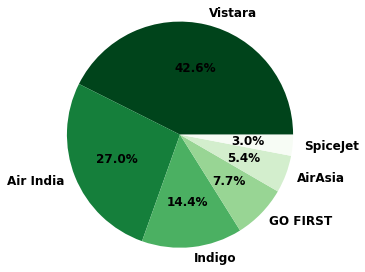

In [15]:
print('List of all the airlines in the data')
print(df.airline.unique())

print('*'*25,'Airline distributions','*'*25)
plt.pie(df.airline.value_counts(), labels= df.airline.value_counts().index, radius=1.3, textprops= {'weight':'bold', 'size': 12},
         autopct='%.1f%%',colors= get_color_codes(plt.cm.Greens_r,df.airline.nunique()))
plt.show()

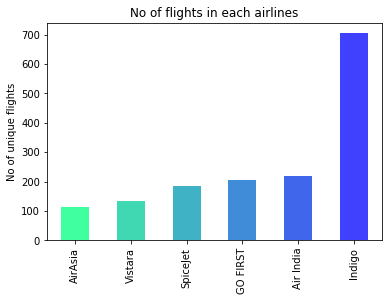

In [16]:
df.groupby('airline').flight.nunique().sort_values().plot(kind='bar', color= get_color_codes(plt.cm.winter_r, 6), alpha=0.75)
plt.title('No of flights in each airlines')
plt.ylabel('No of unique flights')
plt.xlabel('')
plt.show()

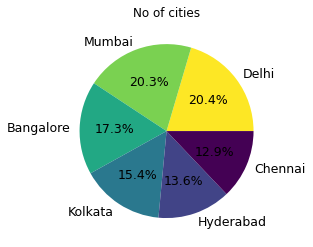

In [17]:
df.source_city.value_counts().plot(kind='pie', colors= get_color_codes(plt.cm.viridis_r, 6), autopct= '%.1f%%',
                                   textprops= {'size':12.5})
plt.ylabel('')
plt.title('No of cities')
plt.show()

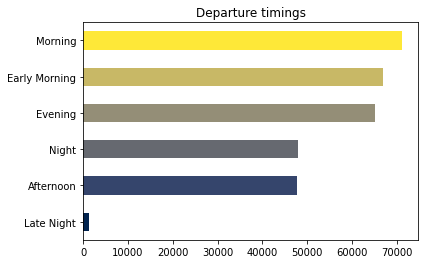

In [18]:
df.departure_time.value_counts(ascending=True).plot(kind='barh', color= get_color_codes('cividis',6))
plt.title('Departure timings')
plt.show()

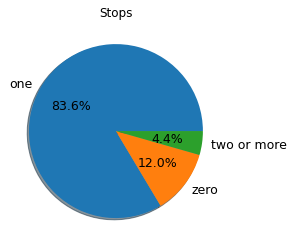

In [19]:
df.stops.value_counts().plot(kind='pie', shadow=True, autopct= '%.1f%%', textprops= {'size':12.5})
plt.title('Stops')
plt.ylabel('')
plt.show()


In [20]:
df.groupby('departure_time').arrival_time.apply(lambda x: x.value_counts().idxmax())

departure_time
Afternoon                Night
Early Morning          Evening
Evening                  Night
Late Night       Early Morning
Morning                Evening
Night                  Morning
Name: arrival_time, dtype: object

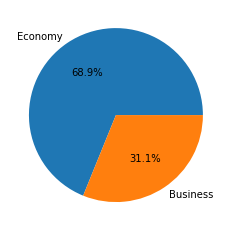

In [21]:
df['class'].value_counts().plot(kind='pie', autopct= '%.1f%%')
plt.ylabel('')
plt.show()

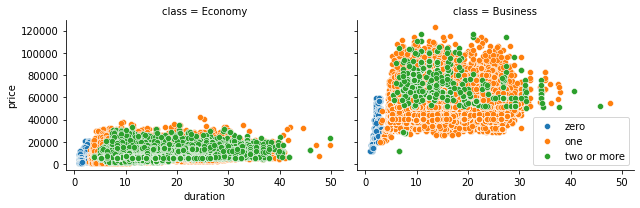

In [22]:
g= sns.FacetGrid(data= df, col= 'class', hue= 'stops',aspect=1.5)
g.map(sns.scatterplot, 'duration', 'price')
plt.legend()

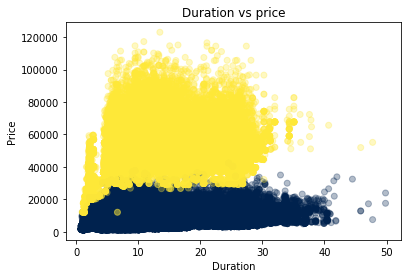

In [23]:
plt.scatter(df.duration, df.price, c= df['class'].map({'Economy':0, 'Business':1}), cmap= 'cividis', alpha=0.3)
plt.title('Duration vs price')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()

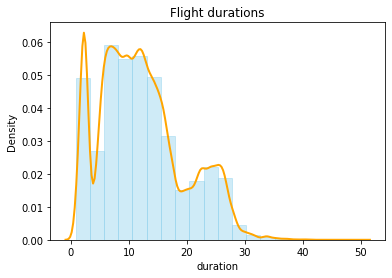

In [24]:
sns.distplot(df.duration, kde_kws= {'lw':2, 'color': 'orange'}, hist_kws= {'color':'skyblue', 'edgecolor':'skyblue'}, bins=20)
plt.title('Flight durations')
plt.show()

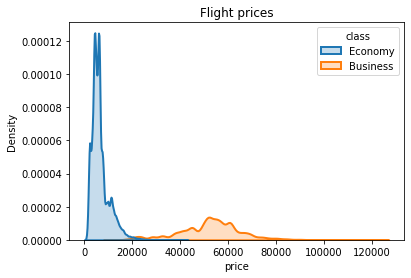

In [25]:
sns.kdeplot(df.price, **{'lw':2, 'color': 'orange'}, shade=True, hue= df['class'])
plt.title('Flight prices')
plt.show()

Text(0.5, 1.0, 'change in prices with no of days left')

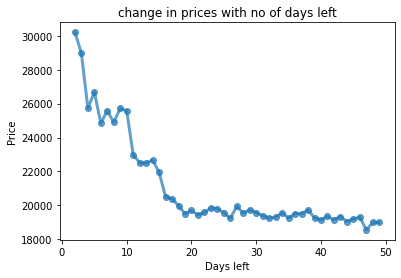

In [26]:
df.groupby('days_left').price.mean()[1:].plot(lw=3, marker='o', alpha=0.7)
plt.ylabel('Price')
plt.xlabel('Days left')
plt.title('change in prices with no of days left')

<AxesSubplot:xlabel='departure_time', ylabel='source_city'>

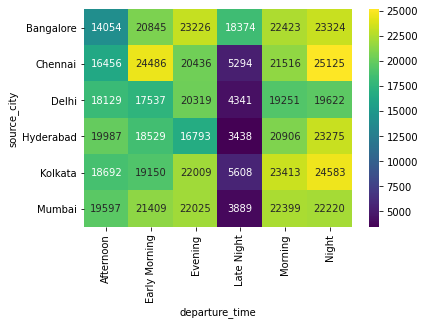

In [27]:
sns.heatmap(pd.crosstab(df.source_city, df.departure_time, values= df.price, aggfunc='mean'),  cmap= 'viridis', fmt= '.0f', annot=True)

In [28]:
def highlight_min_max(v):
    is_max = v > v.mean()
    return ['color: yellow;font-weight:bold' if i else 'color: red;font-weight:bold' for i in is_max]

In [29]:
styler= df.groupby(['source_city','destination_city']).price.mean().unstack().style.format(lambda x: format_numbers(x, fmt='.1f'))
styler.apply(highlight_min_max).highlight_null(null_color='#998e71')

destination_city,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
source_city,,,,,,
Bangalore,nan,23.3K,17.7K,21.2K,23.5K,23.1K
Chennai,25.1K,nan,19.0K,21.6K,22.7K,22.8K
Delhi,17.9K,19.4K,nan,17.3K,20.6K,19.4K
Hyderabad,21.3K,21.8K,17.2K,nan,20.8K,20.1K
Kolkata,22.7K,23.7K,19.4K,21.5K,nan,22.1K
Mumbai,23.1K,22.8K,18.7K,21.0K,22.4K,nan


In [30]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
df_dummy= df.copy()
df_dummy[df_dummy.select_dtypes('O').columns]=df_dummy[df_dummy.select_dtypes('O').columns].apply(LabelEncoder().fit_transform)

<AxesSubplot:>

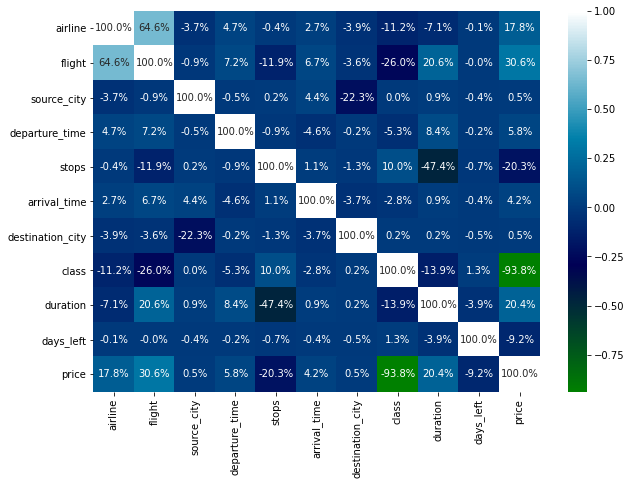

In [31]:
plt.figure(figsize=(10,7))
sns.heatmap(df_dummy.corr(),annot=True, cmap='ocean',fmt= '.1%')

## **Predictive modelling and prediction**

In [10]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
import pickle

### **Training**

In [21]:
## Feature engineering
df['route']= (df.source_city + '_'+ df.destination_city)
df= df.drop(['source_city','destination_city','flight','arrival_time','duration','stops'], axis=1)

In [12]:
def find_outliers(series):
    q1= series.quantile(0.25)
    q3= series.quantile(0.75)
    iqr= q3-q1
    li= q1 - (1.5*iqr)
    ri= q3 + (1.5*iqr)
    return (series < li) | (series > ri)

In [23]:
with open('df.pkl', 'wb') as ref:
    pickle.dump(df, ref)

In [24]:
# df['class']= df['class'].map({'Economy':1, 'Business':0})
df= pd.get_dummies(data= df, columns= ['class','route','departure_time','airline'], drop_first=True)
df.price= df.price.where(~find_outliers(df.price))

In [28]:
df= pd.DataFrame(KNNImputer().fit_transform(df), columns= df.columns)

In [32]:
X= df.drop('price', axis=1)
y= df.price
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= .20)

In [56]:
steps = [('sc',StandardScaler()),
         ('lm', XGBRegressor(max_depth=6, min_child_weight=30, tree_method= 'hist', subsample=0.85, gamma=20, learning_rate=0.1, 
         n_estimators=300))]

pipe= Pipeline(steps= steps)

In [57]:
start= time.time()
pipe.fit(X_train,y_train)
end= time.time()
print('Model trained successfully in %.2f second(s)'%(end-start))

Model trained successfully in 15.44 second(s)


### **Model evaluation**

In [58]:
train_pred= pipe.predict(X_train)
test_pred= pipe.predict(X_test)

print('Training RMSE: %0.3f'%rmse(y_train, train_pred))
print('Testing RMSE: %0.3f'%rmse(y_test, test_pred))

print('Training R2: %0.3f'%mt.r2_score(y_train, train_pred))
print('Testing R2: %0.3f'%mt.r2_score(y_test, test_pred))

Training RMSE: 5978.070
Testing RMSE: 6041.017
Training R2: 0.930
Testing R2: 0.929


In [37]:
# # plot learning curve
# from sklearn.model_selection import cross_val_score, learning_curve

# train_sizes= np.linspace(0.1,0.99, 6)
# train_sizes, train_scores, test_scores= learning_curve(estimator=pipe, X= X, y= y, train_sizes=train_sizes, scoring= mt.make_scorer(rmse)) 

# plt.plot(train_sizes, np.mean(train_scores, axis=1), marker= 'o', lw=3,label= 'Train')
# plt.plot(train_sizes, np.mean(test_scores, axis=1), marker= 'o', lw=3, label= 'Cross validation')
# plt.legend()
# plt.title('Learning curve')
# plt.ylabel('R$^2$')
# plt.xlabel('Training size')

### **Prediction**

In [60]:
predictions= pipe.predict(X_test[:200])

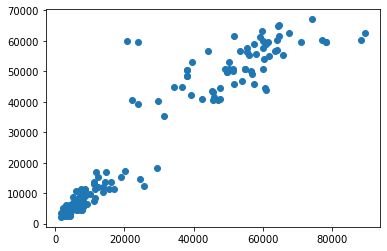

In [61]:
plt.scatter(y_test[:200], predictions)

In [63]:
import pickle
with open('pipe.pkl', 'wb') as ref:
    pickle.dump(pipe, ref)